In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---
### Предсказание заработной платы


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Скачаем данные для обучения и тестирования:

In [4]:
dataset = pd.read_csv("/content/drive/My Drive/AD/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


In [5]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [6]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

In [9]:
train, test = train_test_split(dataset, test_size=0.95)

Подготовим словарь, оставив в нем только наиболее часто встречающиеся токены

In [10]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in train['FullDescription']:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [11]:
list(ordered_dict.items())[:10]

[(' ', 33228),
 ('experience', 13354),
 ('The', 13150),
 ('role', 10499),
 ('work', 10396),
 ('team', 9541),
 ('This', 9041),
 ('within', 8749),
 ('You', 8691),
 ('business', 8165)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [12]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [13]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

In [14]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.DoubleTensor(target)

    texts_tensors = pad_sequence(
        texts_tensors, batch_first=True, padding_value=PAD_IDX_EN
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [15]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [16]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 135, 19, 25000, 25000, 4403, 25000, 34, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4293, 434, 898, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  576, 185, 1626, 648, 0, 25000, 25000, 19964, 19875, 100, ...
Таргет: 72098.0 



Максимальная длина: 2447


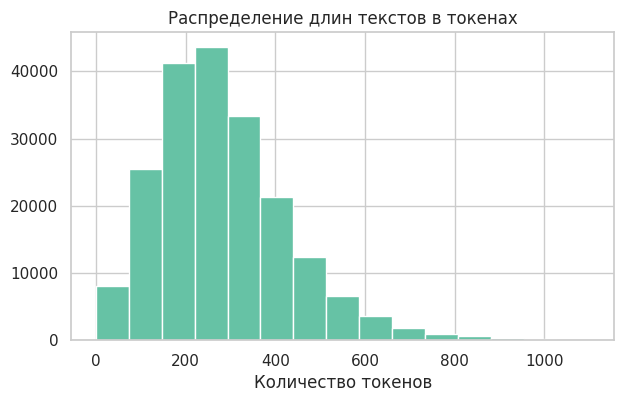

In [17]:
lens = [len(row) for row in tokens]
print("Максимальная длина:", max(lens))

plt.figure(figsize=(7, 4))
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.hist(lens, bins=15, range=(0, 1100))
plt.show();

In [114]:
t_tokens, test_tokens, t_target, test_target = train_test_split(
    tokens, target, test_size = 0.25
)

train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    t_tokens, t_target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))
test_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
test_data = SalaryPredictionDataset(test_tokens, test_target_std)
len(train_data), len(valid_data), len(test_data)

(112500, 37500, 37500)

Посмотрим на отмасштабированные значения зарплаты:

In [115]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1051, 0.1103, 0.0949, ...


Сформируем даталоадеры для обучения и валидации.

In [116]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

In [117]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=128,
        rnn_num_units=16,
        output_dim=1,
        num_layers=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=num_layers)
        self.predictor = nn.Linear(rnn_num_units, 1)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        emb = self.emb(x)
        _, (h_state, _) = self.rnn(emb)


        predictions = self.predictor(h_state.squeeze(0))
        return predictions

In [118]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

In [119]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels.float())
            acc = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [120]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

Обучим несколько моделей с различными гиперпараметрами и сравним их качество на тестовой выборке.

In [121]:
models = []
optimizers = []
histories = [[], [], [], [], [], [], []]

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()

In [124]:
models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=128,
    rnn_num_units=16,
    output_dim=1,
    num_layers = 4
).to(device))
optimizers.append(torch.optim.Adam(models[0].parameters(), lr=0.005))

models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=128,
    rnn_num_units=16,
    output_dim=1,
    num_layers = 4
).to(device))
optimizers.append(torch.optim.Adam(models[1].parameters(), lr=0.015))

models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=128,
    rnn_num_units=16,
    output_dim=1,
    num_layers = 4
).to(device))
optimizers.append(torch.optim.Adam(models[2].parameters(), lr=0.002))

models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=32,
    rnn_num_units=4,
    output_dim=1,
    num_layers = 4
).to(device))
optimizers.append(torch.optim.Adam(models[3].parameters(), lr=0.005))

models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=32,
    rnn_num_units=4,
    output_dim=1,
    num_layers = 1
).to(device))
optimizers.append(torch.optim.Adam(models[4].parameters(), lr=0.005))


models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=32,
    rnn_num_units=4,
    output_dim=1,
    num_layers = 8
).to(device))
optimizers.append(torch.optim.Adam(models[5].parameters(), lr=0.005))

Нулевая модель: размерность эмбеддинга - 128, размерность скрытого состояния - 16, число рекуррентных слоёв - 4, learning rate - 0.005

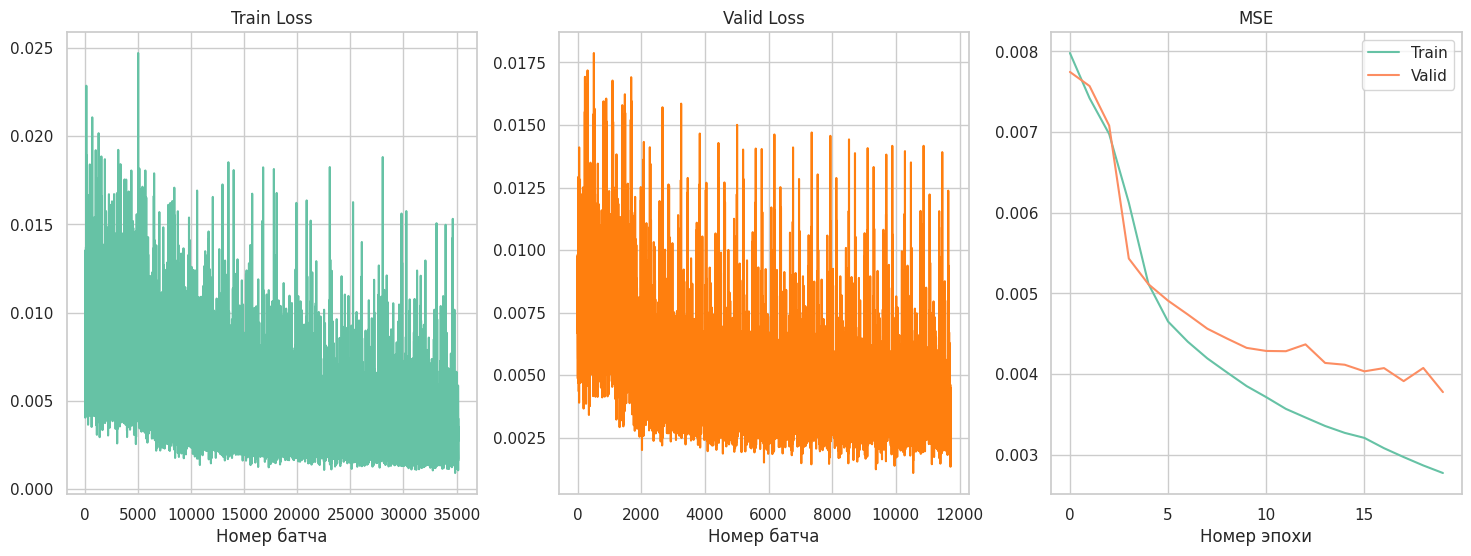

Номер эпохи: 20 | Время обучения эпохи: 0m 32s


In [125]:
optimizer = optimizers[0]
training_loop(models[0], n_epochs=20)

Первая модель: размерность эмбеддинга - 128, размерность скрытого состояния - 16, число рекуррентных слоёв - 4, learning rate - 0.015

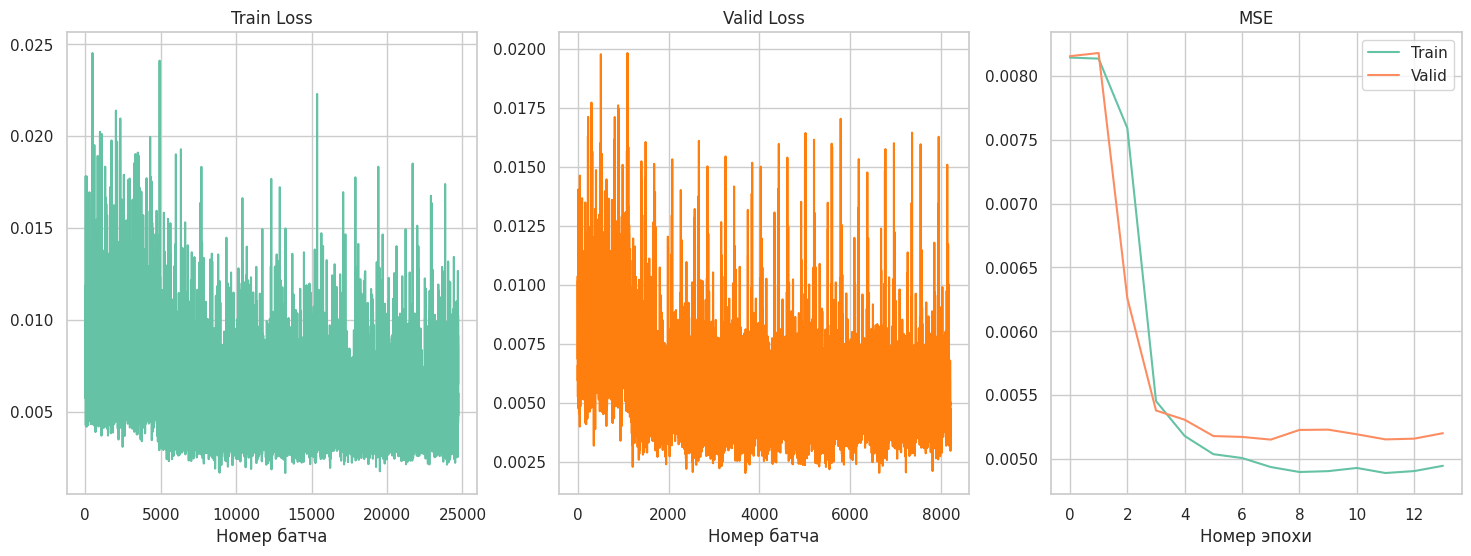

Номер эпохи: 15 | Время обучения эпохи: 0m 25s


In [172]:
optimizer = optimizers[1]
training_loop(models[1], n_epochs=15)

Вторая модель: размерность эмбеддинга - 128, размерность скрытого состояния - 16, число рекуррентных слоёв - 4, learning rate - 0.002

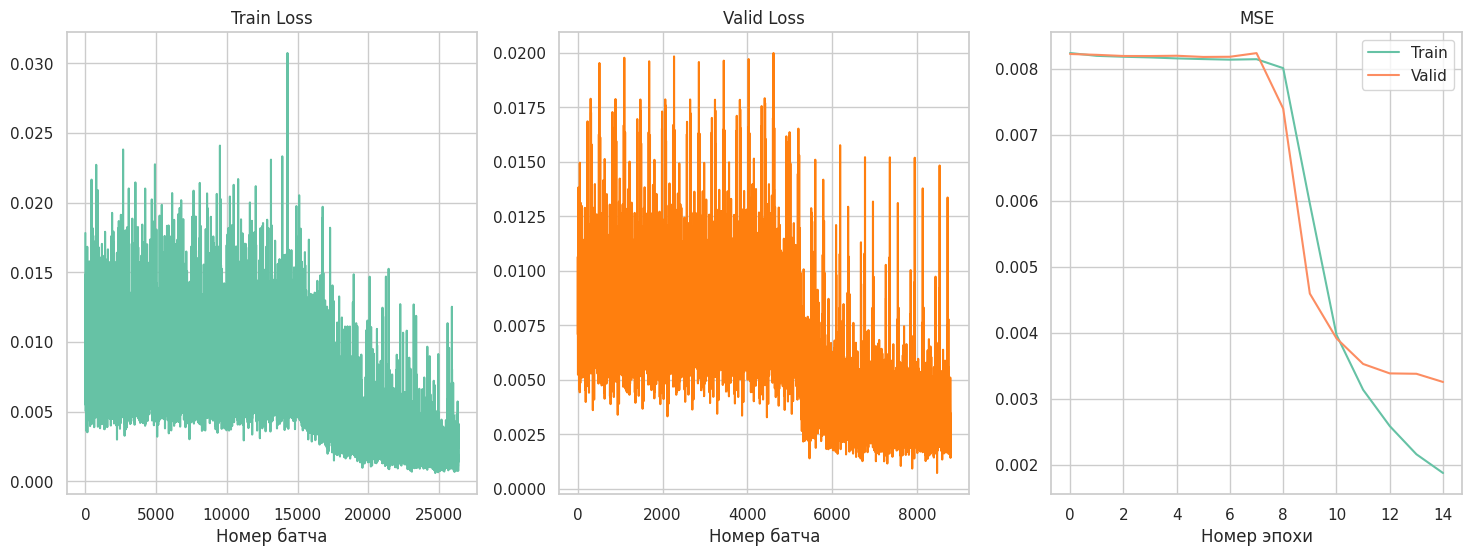

Номер эпохи: 15 | Время обучения эпохи: 0m 26s


In [173]:
optimizer = optimizers[2]
training_loop(models[2], n_epochs=15)

Третья модель: размерность эмбеддинга - 32, размерность скрытого состояния - 4, число рекуррентных слоёв - 4, learning rate - 0.005

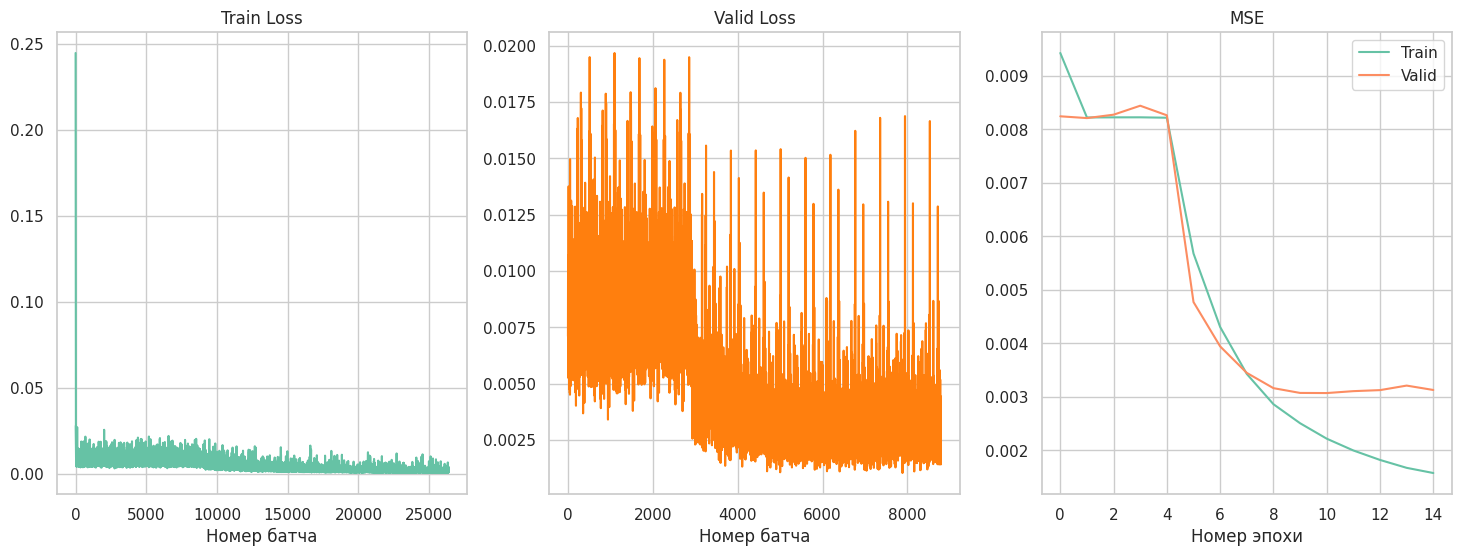

Номер эпохи: 15 | Время обучения эпохи: 0m 21s


In [174]:
optimizer = optimizers[3]
training_loop(models[3], n_epochs=15)

Четвёртая модель: размерность эмбеддинга - 32, размерность скрытого состояния - 4, число рекуррентных слоёв - 1, learning rate - 0.005

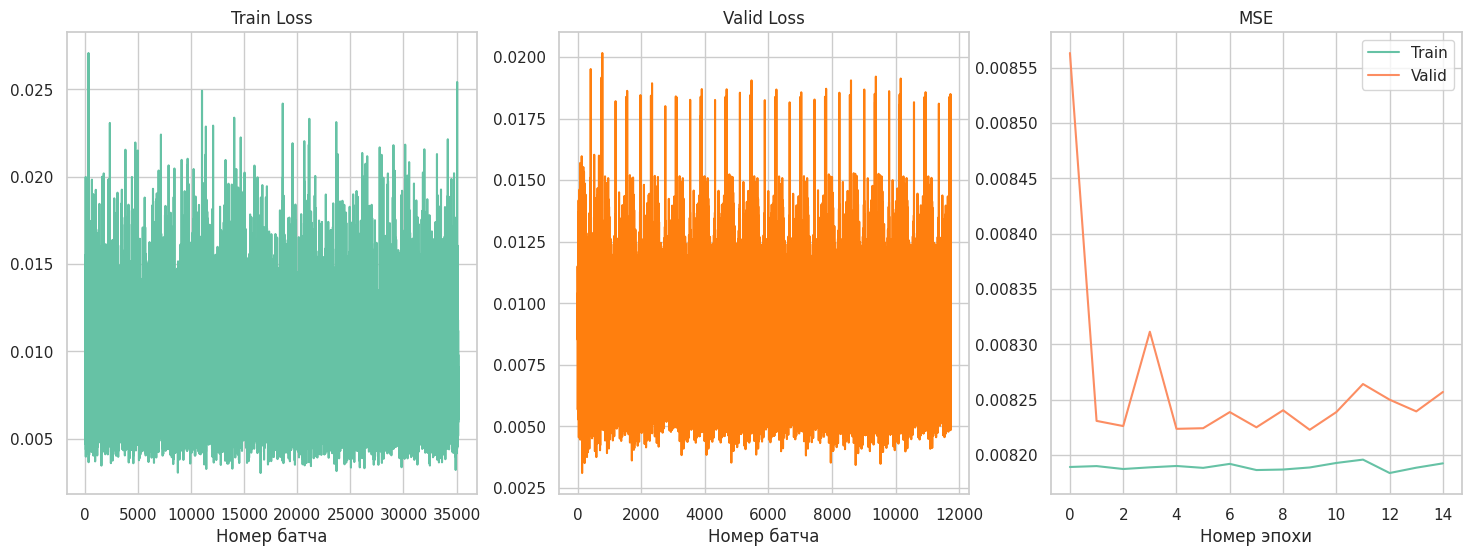

Номер эпохи: 15 | Время обучения эпохи: 0m 22s


In [180]:
optimizer = optimizers[4]
training_loop(models[4], n_epochs=15)

Пятая модель: размерность эмбеддинга - 32, размерность скрытого состояния - 4, число рекуррентных слоёв - 8, learning rate - 0.005

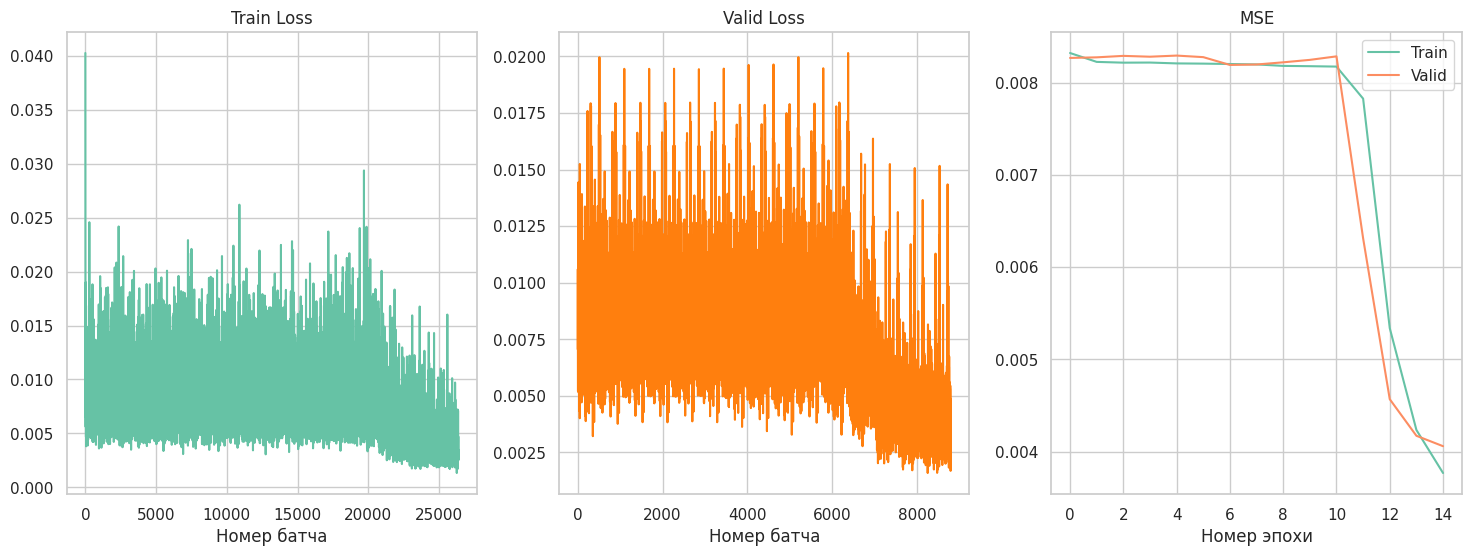

Номер эпохи: 15 | Время обучения эпохи: 0m 31s


In [176]:
optimizer = optimizers[5]
training_loop(models[5], n_epochs=15)

In [177]:
MAX_VOCAB_SIZE = 100  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

# объявим специальные токены
unk_token = "<unk>"
pad_token = "<pad>"

vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]

train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)


# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

In [178]:
models.append(SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=128,
    rnn_num_units=16,
    output_dim=1
).to(device))
optimizers.append(torch.optim.Adam(models[6].parameters(), lr=0.005))

Шестая модель: размерность эмбеддинга - 128, размерность скрытого состояния - 16, число рекуррентных слоёв - 1, learning rate - 0.005, уменьшили размер словаря с 25000 до 100

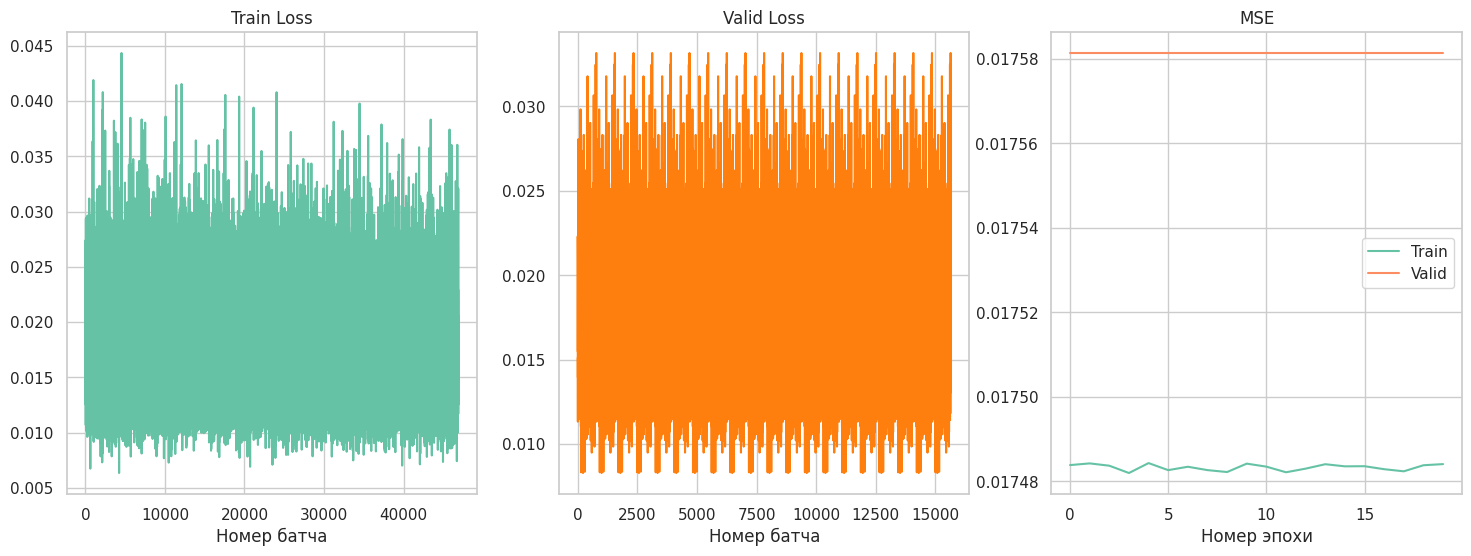

Номер эпохи: 20 | Время обучения эпохи: 0m 33s


In [179]:
optimizer = optimizers[6]
training_loop(models[6], n_epochs=20)

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [166]:
data_batch, labels_batch = next(iter(test_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)
    predictions = models[0](data_batch).squeeze(1)
    result_predictions = predictions[3, :, :]

    labels_transformed = scaler.inverse_transform(np.array(labels_batch.cpu()).reshape(-1, 1))
    result_transformed = scaler.inverse_transform(np.array(result_predictions.cpu()).reshape(-1, 1))


# Выведем предсказания для 5 случайных примеров из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )


    print(text)
    # print(f"Predicted price: {result_predictions[idx].item()}")
    # print(f"True label: {labels_batch[idx].item()}")
    print(f"Predicted price: {round(result_transformed[idx].item(), 1)}")
    print(f"True label: {round(labels_transformed[idx].item(), 1)}")
    print()

Text:
An immediate opportunity arisen experienced Management Accountant join client international world renowned FMCG organisation based London My client offers range excellent employee benefits great office culture renowned flexibility market leading position Key responsibilities Management Accountant job include   Management inventory stock European business   Analysis sales trends demand planning   Cost analysis product lines ranges   Ad hoc MI analysis work   SOX compliance   Management accounts European entity   PL Balance Sheet reconciliations analysis The ideal Management Accountant possess following attributes skills   Strong experience stock inventory   Extensive management accounts experience   An analytical mindset experience various MI reports   Studying professional qualification QBE   SOX experience understanding   Strong IT skills   Good communication skills This excellent opportunity management accountant join well renowned organisation offers extensive exposure develop

In [ ]:
vl_history = []

valid_loss, valid_mse = evaluate(
    models[0], valid_loader, criterion, vl_history
)

In [171]:
print(valid_mse)

0.003775123395440679


**Вывод:**

1. Модели 0, 1 и 2 отличаются только learing rate-ом (0.005, 0.015 и 0.002 соответственно). Время одной эпохи у этих моделей примерно одинаковое. Модель с наибольшим lr первые 2 эпохи показывала одинаковую mse, но затем резко улучшила эту метрику с 0.008 до 0.0055 за 2 эпохи и продолжала держать этот уровень до самого конца. Модель с средним lr стабильнее других уменьшала свою mse, и итоговый результат её был посередине между другими двумя моделями. Лучший показатель mse после 15-ти эпох у модели с наименьшим lr. Первые 8 эпох mse оставалась на одном уровне, затем она резко упала до 0.004 и дальше продолжала снижаться, возможно 15-ти эпох оказалось недостаточно

2. Модели 3, 4 и 5 имеют меньшие размерности эмбеддинга и скрытого состояния, чем первые 3. 3-я отличается от 0-й только этим, она показала метрику 0.003 на valid, а 0-я 0.004, поэтому можно предположить, что таких размерностей достаточно. При этом время её обучения значительно меньше 0-й. Между собой модели 3, 4 и 5 отличаются числом рекуррентных слоёв (4, 1 и 8 соответственно). Модель с 1 рекуррентным слоем (не являющаяся рекуррентной) показала себя ожидаемо хуже всех. После 15-ти эпох лучшая mse у 3-ей модели, однако можно предположить, что обучение 5-й модели не окончено, тогда как у 3-й mse на valid не падала последние 6 эпох. Время обучения 5-й модели наибольшее среди этих трёх

3. Модель 6 отличалась от первых размером словаря, он был значительно меньше - 100 по сравнению с изначальными 25000. Время обучения от предыдущих моделей не отличается. Mse значительно проигрывает первым моделям, составляет 0.018. Тогда как у модели 4, которая, кроме размера словаря, отличается только меньшим размером эмбеддинга и внутренних состояний, mse составляет 0.008

4. У многих моделей на первых 2 - 5 эпохах часто наблюдается отсутсвтие значительного прогресса, зфтем происхоит качественный скачок за несколько эпох. Это можно объяснить общей начальной инициализацией параметров и последующим прорывом градиента

5. Таким образом, если считать метрикой качества модели mse, напрашиваются следующие выводы. Слишком большой learning rate приводит к нестабильности обучения модели, оптимальный lr (в данном случае 0.002 - 0.005) обеспечивает стабильное снижение mse до окончательного уровня. Размерности скрытого состояния и эмбеддинга с какого-то момента становятся излишне большими, занимают больше времени на обучение, при этом не дают выигрыша в метрике. Слишком маленькие размерности приводят к некорректной работе модели. Размер словаря должен быть достаточным, слишком маленький так же приводит к плохим показателям метрики. 1 рекуррентный слой значительно пригрывает большему числу слоёв, потому что устройство моделей становится качественно другим. Увеличение числа слоёв приводит к улучшению метрики, и увеличению времени обучения. Излишне большое количество слоёв может привести к переобучению.

6. Модель хорошо показала себя на тестовой выборке: mse на test (0.0037) немного превышает mse на train (0.0028) и не уступает mse на valid (0.0037)

7. Примеры работы моделей достаточно неплохие, предсказанные зарплаты несильно отличаются от реальных. Даже несложно устроенные RNN неплохо справляются со своей задачей